In [1]:
import re
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import nltk
from nltk import word_tokenize
from nltk.stem import SnowballStemmer, WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer

from scipy.spatial.distance import cosine, jaccard, euclidean, minkowski, braycurtis

In [2]:
train_data = pd.read_csv('data/train.csv');
test_data = pd.read_csv('data/test.csv');
train_data.dropna(inplace=True)

train_data['question1'] = train_data['question1'].apply(str)
train_data['question2'] = train_data['question2'].apply(str)

# test_data = train_data[200000:]
# train_data = train_data[:200000]

print('Total: ', len(train_data['qid1']))
print("Unique: ", len(set(train_data['qid1'])))
train_data.shape, test_data.shape

C:\Users\nikit\AppData\Local\Temp\ipykernel_7708\205658010.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  test_data = pd.read_csv('data/test.csv');


Total:  404287
Unique:  290652


((404287, 6), (3563475, 3))

In [3]:
stemmer = SnowballStemmer('english')
lemmatizer = WordNetLemmatizer()
stop_words = nltk.corpus.stopwords.words('english')

def text_preprocess(text: str) -> str:
    text = re.sub(r'https*\S+', ' ', text)
    text = re.sub(r'@\S+', ' ', text)
    text = re.sub(r'#\S+', ' ', text)
    text = re.sub(r'\'\w+', '', text)
    text = re.sub(r'\w*\d+\w*', '', text)
    text = re.sub(r'\s{2,}', ' ', text)
    text_tokens = word_tokenize(text)
    tokens_without_sw = [word for word in text_tokens if word not
                         in stop_words and len(word) != 1]
    return tokens_without_sw


def text_preprocess_stem(text: str) -> str:
    text = text_preprocess(text)
    # return map(stemmer.stem, text)
    text = [stemmer.stem(i) for i in text]
    return " ".join(text)


def text_preprocess_lem(text: str) -> str:
    text = text_preprocess(text)
    return map(lemmatizer.lemmatize, text)

In [4]:

train_data['question1_stem'] = train_data['question1'].apply(
    text_preprocess_stem)
train_data['question2_stem'] = train_data['question2'].apply(
    text_preprocess_stem)

tfidfvectorizer = TfidfVectorizer(analyzer='word')
tfidfvectorizer.fit(train_data.question1_stem.append(
    train_data.question2_stem))

C:\Users\nikit\AppData\Local\Temp\ipykernel_7708\1197713778.py:7: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tfidfvectorizer.fit(train_data.question1_stem.append(


TfidfVectorizer()

In [5]:
t1 = tfidfvectorizer.transform(train_data.question1_stem.values)
t2 = tfidfvectorizer.transform(train_data.question2_stem.values)

In [6]:

cos_dist = [cosine(i.toarray()[0], j.toarray()[0]) for i, j in zip(t1, t2)]
cos_dist = np.array(cos_dist)

# jac_dist = [jaccard(i.toarray()[0], j.toarray()[0]) for i, j in zip(t1, t2)]
# jac_dist = np.array(jac_dist)

# euc_dist = [euclidean(i.toarray()[0], j.toarray()[0]) for i, j in zip(t1, t2)]
# euc_dist = np.array(euc_dist)

min_dist = [minkowski(i.toarray()[0], j.toarray()[0]) for i, j in zip(t1, t2)]
min_dist = np.array(min_dist)

bra_dist = [braycurtis(i.toarray()[0], j.toarray()[0]) for i, j in zip(t1, t2)]
bra_dist = np.array(bra_dist)

c:\Users\nikit\Documents\XXX\nlp\venv\lib\site-packages\scipy\spatial\distance.py:630: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


In [ ]:
from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer('multi-qa-MiniLM-L6-cos-v1')

embeddings1 = model.encode(train_data.question1.values, convert_to_tensor=True)
embeddings2 = model.encode(train_data.question2.values, convert_to_tensor=True)

cosine_scores = util.cos_sim(embeddings1, embeddings2)

In [ ]:
plt.hist([
    cosine_scores[np.where(train_data['is_duplicate'])[0]],
    cosine_scores[np.where(train_data['is_duplicate'] == False)[0]]
], color=['r', 'b'], alpha=0.5)

(array([[32450., 24118., 24293., 22538., 19472., 13779.,  8025.,  3538.,
           859.,   191.],
        [16014., 25524., 27689., 25866., 28998., 32356., 29606., 20956.,
         11225., 36790.]]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 2 BarContainer objects>)

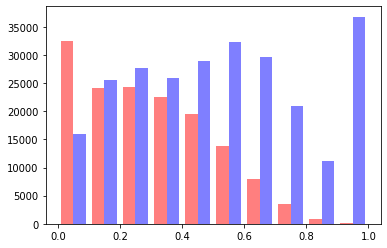

In [7]:
plt.hist([
    cos_dist[np.where(train_data['is_duplicate'])[0]],
    cos_dist[np.where(train_data['is_duplicate'] == False)[0]]
], color=['r', 'b'], alpha=0.5)

(array([[1.74310e+04, 1.30000e+01, 5.70000e+01, 2.00000e+00, 4.00000e+00,
         4.00000e+00, 0.00000e+00, 0.00000e+00, 2.00000e+00, 1.31750e+05],
        [7.18200e+03, 4.70000e+01, 8.20000e+01, 7.80000e+01, 1.32000e+02,
         6.00000e+01, 2.00000e+00, 1.00000e+00, 5.00000e+00, 2.47435e+05]]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 2 BarContainer objects>)

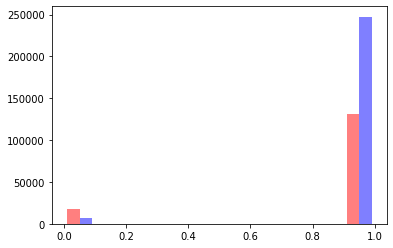

In [8]:
plt.hist([
    jac_dist[np.where(train_data['is_duplicate'])[0]],
    jac_dist[np.where(train_data['is_duplicate'] == False)[0]]
], color=['r', 'b'], alpha=0.5)

(array([[17829.,  2471.,  9829., 16544., 22021., 26051., 26410., 19343.,
          7859.,   906.],
        [ 7257.,  1057.,  5847., 15988., 25687., 28675., 36418., 48190.,
         39466., 46439.]]),
 array([0.        , 0.14142136, 0.28284271, 0.42426407, 0.56568542,
        0.70710678, 0.84852814, 0.98994949, 1.13137085, 1.27279221,
        1.41421356]),
 <a list of 2 BarContainer objects>)

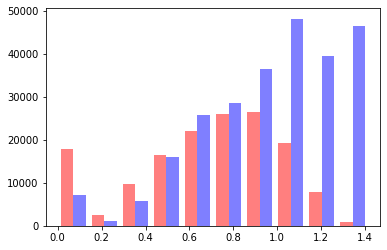

In [9]:
plt.hist([
    euc_dist[np.where(train_data['is_duplicate'])[0]],
    euc_dist[np.where(train_data['is_duplicate'] == False)[0]]
], color=['r', 'b'], alpha=0.5)

(array([[17829.,  2471.,  9829., 16544., 22021., 26051., 26410., 19343.,
          7859.,   906.],
        [ 7257.,  1057.,  5847., 15988., 25687., 28675., 36418., 48190.,
         39466., 46439.]]),
 array([0.        , 0.14142136, 0.28284271, 0.42426407, 0.56568542,
        0.70710678, 0.84852814, 0.98994949, 1.13137085, 1.27279221,
        1.41421356]),
 <a list of 2 BarContainer objects>)

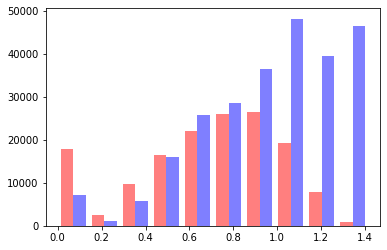

In [10]:
plt.hist([
    min_dist[np.where(train_data['is_duplicate'])[0]],
    min_dist[np.where(train_data['is_duplicate'] == False)[0]]
], color=['r', 'b'], alpha=0.5)

(array([[21104., 18955., 24295., 25428., 25033., 19061., 11190.,  3495.,
           609.,    93.],
        [ 8698., 17203., 27201., 24886., 26948., 32581., 36904., 29412.,
         15361., 35830.]]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 2 BarContainer objects>)

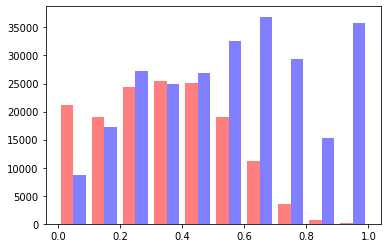

In [11]:
plt.hist([
    bra_dist[np.where(train_data['is_duplicate'])[0]],
    bra_dist[np.where(train_data['is_duplicate'] == False)[0]]
], color=['r', 'b'], alpha=0.5)

In [7]:
def common_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1_stem'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2_stem'].split(" ")))    
    return len(w1 & w2)


train_data['word_common'] = train_data.apply(common_words, axis=1)


number_words1 = train_data['question1_stem'].apply(lambda row: len(row.split(" ")))
number_words2 = train_data['question2_stem'].apply(lambda row: len(row.split(" ")))

train_data['q1_num_words'] = number_words1
train_data['q2_num_words'] = number_words2
train_data["number_words_diff"] = np.absolute(number_words1 - number_words2)

In [8]:
def total_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1_stem'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2_stem'].split(" ")))    
    return (len(w1) + len(w2))

train_data['word_total'] = train_data.apply(total_words, axis=1)

In [9]:
train_data['word_share'] = round(train_data['word_common']/train_data['word_total'], 2)

In [10]:
train_data['q1_len'] = train_data['question1_stem'].str.len() 
train_data['q2_len'] = train_data['question2_stem'].str.len()

In [11]:
train_data['cos_dist'] = cos_dist
# train_data['jac_dist'] = jac_dist
# train_data['euc_dist'] = euc_dist
train_data['min_dist'] = min_dist
train_data['bra_dist'] = bra_dist

In [12]:
import xgboost as xgb

In [13]:
X = train_data.loc[:300001, ['cos_dist','min_dist', 'bra_dist', 'number_words_diff', 'word_common', 'q1_num_words', 'q2_num_words', 'q1_len', 'q1_len', 'word_share']].to_numpy()
y = train_data.loc[:300001, 'is_duplicate'].to_numpy()
X_test = train_data.loc[300001:, ['cos_dist','min_dist', 'bra_dist', 'number_words_diff', 'word_common', 'q1_num_words', 'q2_num_words', 'q1_len', 'q1_len', 'word_share']].to_numpy()
y_test = train_data.loc[300001:, 'is_duplicate'].to_numpy()

In [12]:
from sklearn.model_selection import RandomizedSearchCV

parameters = {'objective':['reg:squarederror'],
              'booster':['gbtree','gblinear'],
              'learning_rate': [0.1], 
              'max_depth': [10,15,18, 8],
              'min_child_weight': [8, 10,15],
              'colsample_bytree': [0.85, 0.9, 0.95],
              'n_estimators': [600, 800, 1000],
              "reg_alpha"   : [0.2,0.1],
              "reg_lambda"  : [2,1],
              "gamma"       : [1]}

xgb_model = xgb.XGBRegressor(random_state=30)

grid_obj_xgb = RandomizedSearchCV(xgb_model,parameters, cv=5,n_iter=7, scoring='neg_mean_absolute_error',verbose=5, n_jobs=20)
grid_obj_xgb.fit(X, y, verbose=1)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, gamma=None,
                                          gpu_id=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None, max_bin=None,
                                          m...
                                          reg_alpha=None, reg_lambda=None, ...),
                   n_iter=5, n_jobs=12,
                   param_distributions={'booster': ['gbtree', 'gblinear'],
                                        'colsample_bytree': [0.8, 0.9, 1],
                                        'gamma': [1, 2], 'learning_rate': [0.1],
                                        'max_depth': [10, 15, 20],
                                        'min_child_weight': [10, 15, 25],
                                        'n_estimators': [300, 450, 600],
                                        'objective': ['reg:squarederror'],
                                        'reg_alpha': [0.5, 0.2, 1],
                                        'reg_lambda': [2, 4]},
                   scoring='neg_mean_absolute_error', verbose=5)

In [14]:
grid_obj_xgb.best_params_

{'reg_lambda': 2,
 'reg_alpha': 0.2,
 'objective': 'reg:squarederror',
 'n_estimators': 600,
 'min_child_weight': 10,
 'max_depth': 10,
 'learning_rate': 0.1,
 'gamma': 1,
 'colsample_bytree': 0.9,
 'booster': 'gbtree'}

In [15]:
param = {'reg_lambda': 2,
 'reg_alpha': 0.2,
 'objective': 'reg:squarederror',
 'n_estimators': 500,
 'min_child_weight': 7,
 'max_depth': 11,
 'learning_rate': 0.15,
 'gamma': 1,
 'colsample_bytree': 0.9,
 'booster': 'gbtree'}

xg_reg = xgb.XGBRegressor(**param)
xg_reg.fit(X, y)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.9,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=1, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.15, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=11, max_leaves=0, min_child_weight=7,
             missing=nan, monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0.2, reg_lambda=2, ...)

In [16]:
y_pred = xg_reg.predict(X_test)

In [17]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [18]:
fpr1, tpr1, thresh1 = roc_curve(y_test, y_pred, pos_label=1)
print(roc_auc_score(y_test, y_pred))

0.8004225509936806


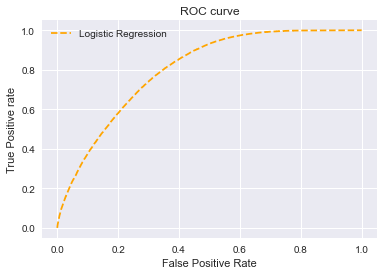

In [19]:
plt.style.use('seaborn')
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='Logistic Regression')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.show();

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
clf.fit(X, y)
y_pred_forest = clf.predict(X_test)

In [ ]:
fpr1, tpr1, thresh1 = roc_curve(y_test, y_pred_forest, pos_label=1)
print(roc_auc_score(y_test, y_pred_forest))
